In [31]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense ,Dropout
from keras.optimizers import Adam
import time

# remplacer les valeurs manquantes par **le moyenne de chaque state**

In [44]:
# Load the dataset
df=pd.read_csv('Water_dataX_mean_state_hong_kong.csv')
cols_to_drop=['water control zone','river','station','dates','sample no','wqi','wqi clf']
# Diviser les données en caractéristiques et cibles
# Split the dataset into input (X) and output (y) variables
X =  df.drop(cols_to_drop, axis=1)
y = df["wqi"].values

In [45]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
# Reshape the input features for use with CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [48]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1, activation='linear'))

In [49]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae')

In [50]:
import time

# Début du chrono
start_time_mean_state = time.time()
# Enregistrer les temps de départ
step_times = []

# Définir un callback pour mesurer les temps de chaque étape
class TimingCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        self.start_time = time.time()

    def on_train_batch_end(self, batch, logs=None):
        step_time = time.time() - self.start_time
        step_times.append(step_time)
# Train the model
history_mean_zone=model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test),callbacks=[TimingCallback()])
# Fin du chrono
end_time_mean_state = time.time()

Epoch 1/1000
764/764 [==============================] - 6s 7ms/step - loss: 6.4545 - val_loss: 2.4446
Epoch 2/1000
764/764 [==============================] - 6s 8ms/step - loss: 2.0228 - val_loss: 2.4756
Epoch 3/1000
764/764 [==============================] - 6s 7ms/step - loss: 1.5867 - val_loss: 1.3753
Epoch 4/1000
764/764 [==============================] - 7s 9ms/step - loss: 1.4224 - val_loss: 2.4327
Epoch 5/1000
764/764 [==============================] - 6s 8ms/step - loss: 1.4035 - val_loss: 1.5710
Epoch 6/1000
764/764 [==============================] - 6s 8ms/step - loss: 1.3613 - val_loss: 1.5059
Epoch 7/1000
764/764 [==============================] - 6s 8ms/step - loss: 1.2953 - val_loss: 1.6303
Epoch 8/1000
764/764 [==============================] - 6s 8ms/step - loss: 1.2632 - val_loss: 1.3675
Epoch 9/1000
764/764 [==============================] - 6s 8ms/step - loss: 1.2316 - val_loss: 1.0695
Epoch 10/1000
764/764 [==============================] - 6s 8ms/step - loss: 1.224

In [51]:
# Calcul de la durée d'entraînement en secondes
training_time_mean_state = end_time_mean_state - start_time_mean_state
# Affichage de la durée d'entraînement
print("Le temps d'entraînement est de", training_time_mean_state, "secondes")
# Evaluate the model
loss_mean_state = model.evaluate(X_test, y_test)

Le temps d'entraînement est de 6817.810097694397 secondes
191/191 [==============================] - 1s 3ms/step - loss: 0.6474


In [52]:
# Predict the WQI for a new sample
new_sample = np.array([[7.5, 8.0, 300, 2.0, 0.5, 100, 2005,20,30]])
new_sample = scaler.transform(new_sample)
new_sample = new_sample.reshape((new_sample.shape[0], new_sample.shape[1], 1))
prediction = model.predict(new_sample)
print('Predicted WQI:', prediction[0][0])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 201ms/step
Predicted WQI: 503.27478


*comparaison*

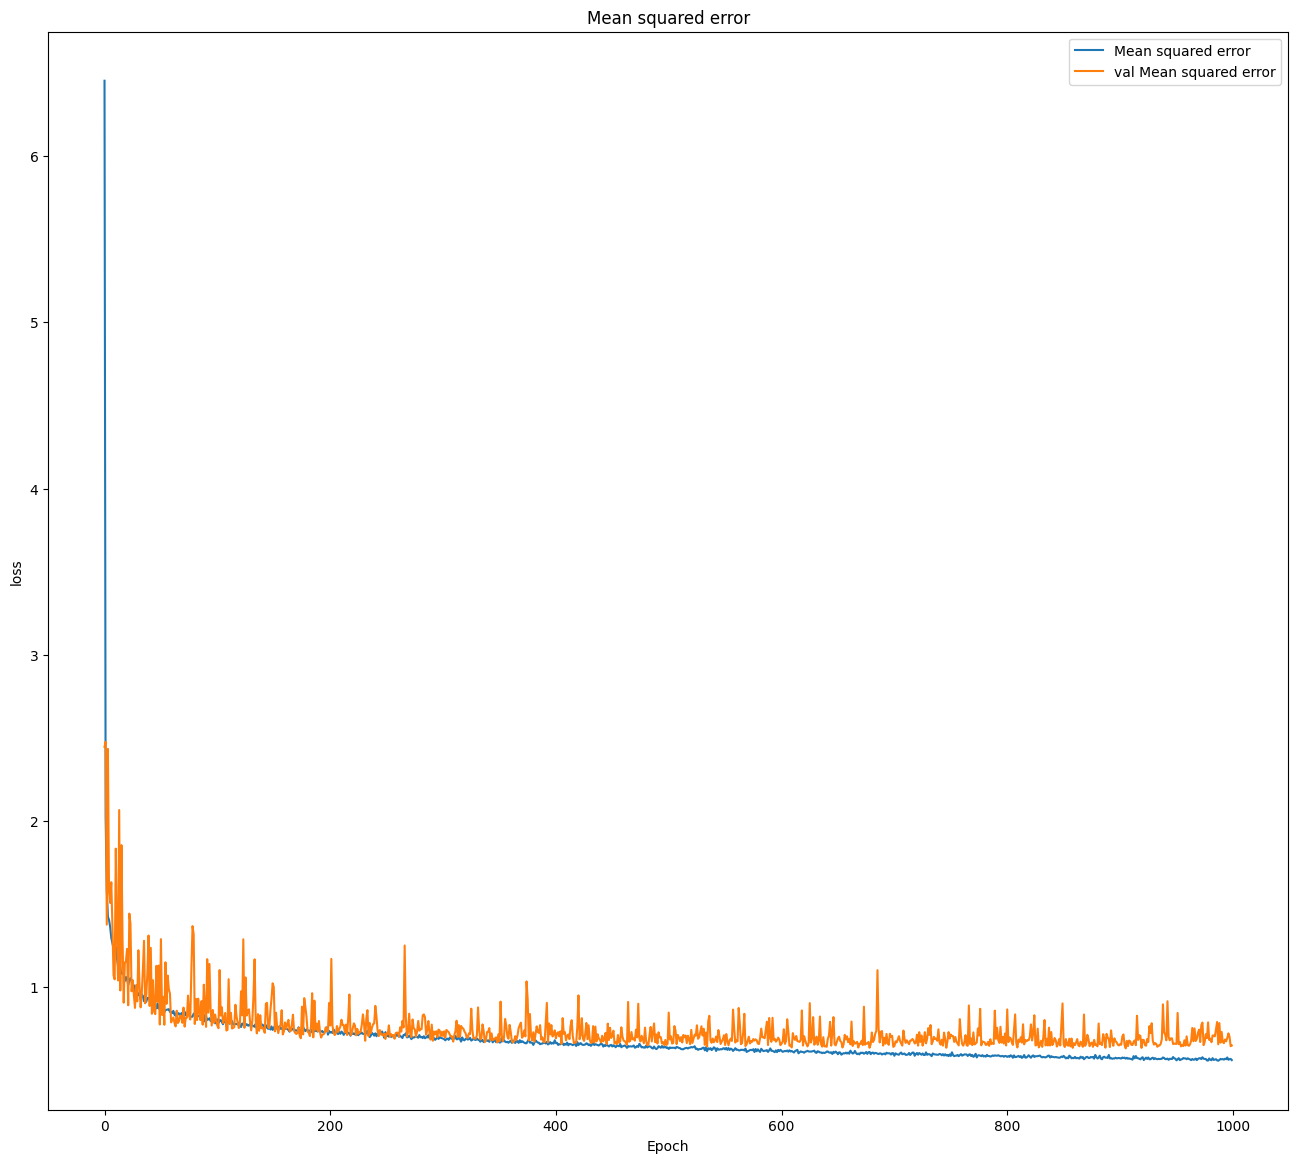

In [53]:
# Afficher les graphes d'accuracy et loss selon l'epoch
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(14, 12))
plt.plot(history_mean_zone.history['loss'], label='Mean squared error')
plt.plot(history_mean_zone.history['val_loss'], label='val Mean squared error')
plt.title('Mean squared error')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
# agrandir la taille de la figure
fig.set_size_inches(16, 14)
plt.show()

In [54]:
model.save('prediction_wqi_par_cnn_hong_kong_v3.h5')